In [3]:
import folium # Importing GeoJson class from folium library for visualizing geospatial data
import json # Importing json module for working with JSON data
import os # Importing os module for accessing operating system dependent functionality
import pandas as pd # Importing pandas library and aliasing it as pd for data analysis and manipulation
import matplotlib.pyplot as plt # Importing pyplot module from matplotlib library and aliasing it as plt for plotting
import scipy.signal # Importing signal module from scipy library for signal processing
import numpy as np # Importing numpy library and aliasing it as np for numerical computing
import geopandas as gpd # Importing geopandas library and aliasing it as gpd for working with geographic data
import openeo # Importing openeo library for working with the OpenEO API for Earth Observation data processing
from shapely.geometry import shape # Importing shape class from geometry module of shapely library for geometric operations
from shapely.geometry import Point # Importing Point class from geometry module of shapely library for representing a point in space

In [4]:
connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

In [5]:
# Load the GeoJSON file as a GeoDataFrame
#landfill_1500m = gpd.read_file(r"C:\GIS_Course\EGM722\Project\Data\PZ_landfill_point4326.geojson")

# Convert the CRS to EPSG:2062
#landfill_1500m = landfill_1500m.to_crs(epsg=2062)

# Add a buffer of 1000m to each point
#landfill_1500m['geometry'] = landfill_1500m.buffer(1000)

# Convert the CRS back to EPSG:4326
#landfill_1500m = landfill_1500m.to_crs(epsg=4326)

# Convert from dataframe to GeoJSON
#landfill_1500m_geojson = landfill_1500m.__geo_interface__

# Load the GeoJSON point file while the buffer isn't working
def read_json(filename: str) -> dict:
  with open(filename,encoding="utf-8") as input:
    field = json.load(input)
    return field

landfill = read_json(r"C:\GIS_Course\EGM722\Project\Data\PZ_landfill_point4326.geojson")


In [6]:
s5cube_timeseries = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=["2023-02-01", "2023-03-01"],
    bands=["CH4"], # options for gas monitoring 'CO', 'HCHO', 'NO2', 'O3', 'SO2', 'CH4'
)

In [7]:
timeseries = s5cube_timeseries.aggregate_spatial(geometries=landfill, reducer="mean")


In [8]:
job = timeseries.execute_batch(out_format="CSV", title="CH4 timeseries")

0:00:00 Job 'j-240417172ae94057b4ed02ac4440ae03': send 'start'
0:00:15 Job 'j-240417172ae94057b4ed02ac4440ae03': created (progress N/A)
0:00:20 Job 'j-240417172ae94057b4ed02ac4440ae03': created (progress N/A)
0:00:27 Job 'j-240417172ae94057b4ed02ac4440ae03': created (progress N/A)
0:00:35 Job 'j-240417172ae94057b4ed02ac4440ae03': created (progress N/A)
0:00:45 Job 'j-240417172ae94057b4ed02ac4440ae03': created (progress N/A)
0:00:58 Job 'j-240417172ae94057b4ed02ac4440ae03': created (progress N/A)
0:01:14 Job 'j-240417172ae94057b4ed02ac4440ae03': running (progress N/A)
0:01:34 Job 'j-240417172ae94057b4ed02ac4440ae03': running (progress N/A)
0:01:59 Job 'j-240417172ae94057b4ed02ac4440ae03': running (progress N/A)
0:02:29 Job 'j-240417172ae94057b4ed02ac4440ae03': running (progress N/A)
0:03:09 Job 'j-240417172ae94057b4ed02ac4440ae03': running (progress N/A)
0:03:56 Job 'j-240417172ae94057b4ed02ac4440ae03': running (progress N/A)
0:04:55 Job 'j-240417172ae94057b4ed02ac4440ae03': finished (p

In [9]:
job.get_results().download_file("CH4-results/CH4_timeseries.csv")

pd.read_csv("CH4-results/CH4_timeseries.csv", index_col=0)


,feature_index,avg(band_0)
date,,
2023-02-28T00:00:00.000Z,0,1892.606567
2023-02-28T00:00:00.000Z,20,NaN
2023-02-28T00:00:00.000Z,5,NaN
2023-02-28T00:00:00.000Z,15,NaN
2023-02-28T00:00:00.000Z,14,NaN
...,...,...
2023-02-01T00:00:00.000Z,10,NaN
2023-02-01T00:00:00.000Z,16,NaN
2023-02-02T00:00:00.000Z,3,NaN


In [10]:
def plot_timeseries(filename, figsize=(15, 10)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("CH4")
    ax.set_ylim(1800, 2000)
    ax.legend(title="parcel id", loc='upper left', bbox_to_anchor=(1.02, 1), ncol=2)
    ax.xaxis.set_major_locator(plt.MaxNLocator(20))
    ax.grid(True)


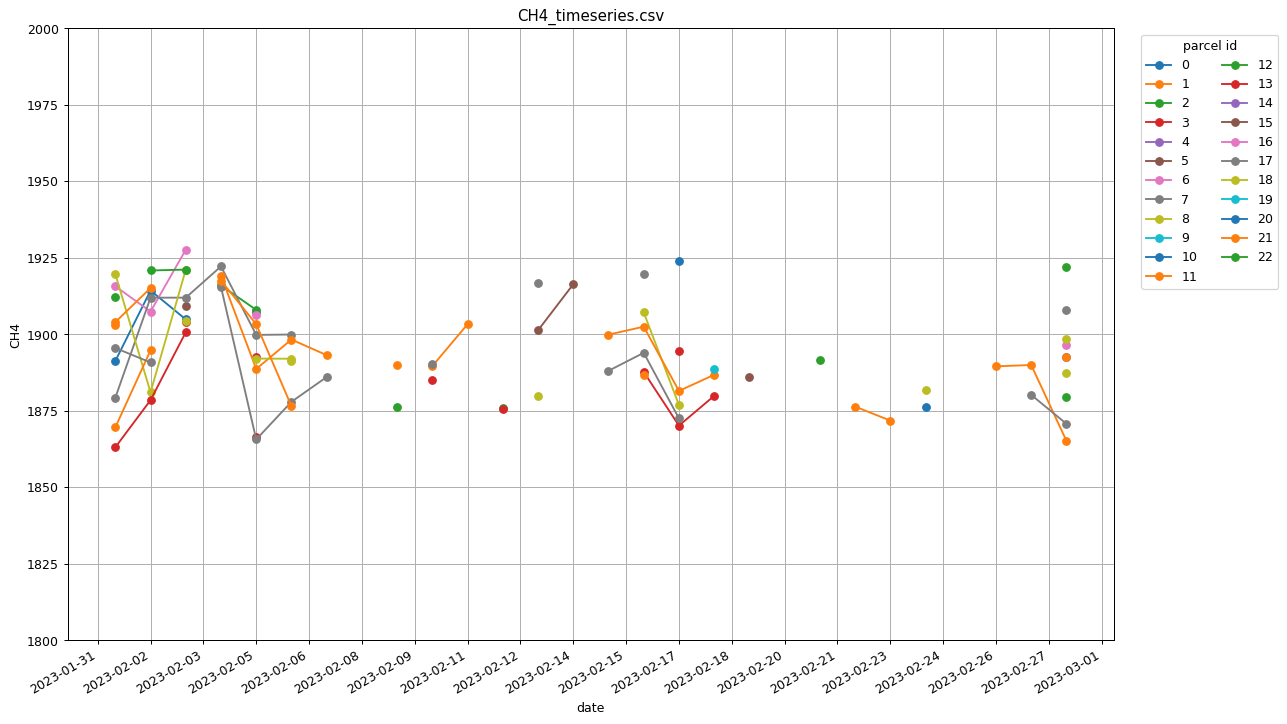

In [11]:
plot_timeseries("CH4-results/CH4_timeseries.csv")
